# Inventory Optimisation Exploratory Data Analysis

In this kernel we'll be building a Inventory Management System using https://nhsrcindia.org/HCT-DME?page=%2C4 (Oshida state) Dataset.

The model goal is to provide accurate demand forecasting which can efficiently provide a decision basis for the replenishment of stocks in a medical institution. 

In [1]:
# Import libraries
import os
import re
import glob
import datetime

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from pca import pca as pca_2

# Data Preparation

## Part I: Identifying missing, duplicated or noisy data

In [2]:
# load the dataset
df = pd.read_excel(r"data.xlsx")
print(df.shape)

(5593, 18)


In [3]:
df.head(4)

,State,District,Facility,Category,Equipment Name,Cost,Serial No.,Department,Manufacturer,Model,Price,Date Of Installation,Under Warranty,Warranty Expiry Date,Functional/ Non-functional,Status,Return Date,Borrow Date
0,Odisha,Cuttack,AHRCC(Cuttack),Diagnostic/Monitoring,ABG,1000000.0,RG59vtM,ICU,Alera,Epoc,690900.0,2021-04-08,Yes,2026-04-07,Functional,Not Available,NaN,NaN
1,Odisha,Cuttack,AHRCC(Cuttack),Diagnostic/Monitoring,ABG,1000000.0,WX17vxI,ICU,Alera,Epoc,690900.0,2021-04-08,Yes,2026-04-07,Functional,Not Available,NaN,NaN
2,Odisha,Cuttack,AHRCC(Cuttack),Anestesia,ANESTESIA WORK STETION,450000.0,AL32ffX,OT,L and T Medical Equipment and systems,615,1167685.0,2021-07-13,Yes,2023-11-11,Functional,Available,NaN,NaN
3,Odisha,Cuttack,AHRCC(Cuttack),Anestesia,ANESTESIA WORK STETION,450000.0,XF82dcH,OT,L and T Medical Equipment and systems,615,1167685.0,2021-07-13,Yes,2023-11-11,Functional,Available,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5593 entries, 0 to 5592
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   State                       5593 non-null   object        
 1   District                    5593 non-null   object        
 2   Facility                    5593 non-null   object        
 3   Category                    4380 non-null   object        
 4   Equipment Name              5593 non-null   object        
 5   Cost                        5207 non-null   float64       
 6   Serial No.                  5593 non-null   object        
 7   Department                  5593 non-null   object        
 8   Manufacturer                5568 non-null   object        
 9   Model                       5593 non-null   object        
 10  Price                       5593 non-null   float64       
 11  Date Of Installation        5593 non-null   datetime64[n

> Drop 'State', 'District', 'Facility', 'Serial No.', 
       'Department','Manufacturer','Model', 'Warranty Expiry Date', 
       'Return Date', 'Borrow Date', atrributes as it is not meaningful/there are too many missing data with vague definition 

In [5]:
dataset = df.drop(['State', 'District', 'Facility',
                   'Department','Manufacturer','Model','Warranty Expiry Date',
                   'Return Date', 'Borrow Date'], axis = 1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5593 entries, 0 to 5592
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Category                    4380 non-null   object        
 1   Equipment Name              5593 non-null   object        
 2   Cost                        5207 non-null   float64       
 3   Serial No.                  5593 non-null   object        
 4   Price                       5593 non-null   float64       
 5   Date Of Installation        5593 non-null   datetime64[ns]
 6   Under Warranty              5498 non-null   object        
 7   Functional/ Non-functional  5593 non-null   object        
 8   Status                      5593 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 393.4+ KB


> Check 'Cost' and 'Price' attributes

In [6]:
priceFreq_df = dataset['Price'].value_counts().sort_index()
priceFreq_df

Price
0.0           2762
250.0            1
345.0            1
394.0            7
397.0            1
              ... 
10500000.0       1
12521112.0       1
13066558.0       1
30049166.0       1
32500000.0       1
Name: count, Length: 790, dtype: int64

In [7]:
costFreq_df = dataset['Cost'].value_counts().sort_index()
costFreq_df

Cost
0.0             1
100.0          14
1000.0        232
1200.0         49
1500.0         21
             ... 
13000000.0      1
15000000.0      1
16000000.0      1
25000000.0      1
30000000.0      2
Name: count, Length: 77, dtype: int64

> With >50% incorrect data values for 'Price' attribute, the attribute is dropped

In [8]:
dataset = dataset.drop(['Price'], axis = 1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5593 entries, 0 to 5592
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Category                    4380 non-null   object        
 1   Equipment Name              5593 non-null   object        
 2   Cost                        5207 non-null   float64       
 3   Serial No.                  5593 non-null   object        
 4   Date Of Installation        5593 non-null   datetime64[ns]
 5   Under Warranty              5498 non-null   object        
 6   Functional/ Non-functional  5593 non-null   object        
 7   Status                      5593 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 349.7+ KB


 > Check for min, max and unique values for each attribute

In [9]:
stats_df =  dataset[['Equipment Name','Cost','Date Of Installation','Functional/ Non-functional']]
dataset_stats = pd.DataFrame(stats_df.max(axis=0))
dataset_stats.columns = ['MaxValues']
dataset_stats['MinValues'] = stats_df.min(axis=0)
dataset_stats

,MaxValues,MinValues
Equipment Name,ultrasound Scanner,100MA X-Ray Machine
Cost,30000000.0,0.0
Date Of Installation,2022-11-22 00:00:00,1906-12-29 00:00:00
Functional/ Non-functional,condemed,Functional


> Drop entries where cost is 0. 

In [10]:
dataset = dataset[dataset['Cost'] != 0]

In [11]:
stats_df =  dataset[['Equipment Name','Cost','Date Of Installation','Functional/ Non-functional']]
dataset_stats = pd.DataFrame(stats_df.max(axis=0))
dataset_stats.columns = ['MaxValues']
dataset_stats['MinValues'] = stats_df.min(axis=0)
dataset_stats

,MaxValues,MinValues
Equipment Name,ultrasound Scanner,100MA X-Ray Machine
Cost,30000000.0,100.0
Date Of Installation,2022-11-22 00:00:00,1906-12-29 00:00:00
Functional/ Non-functional,condemed,Functional


In [12]:
dataset_unq = pd.DataFrame(index=list(dataset.columns))
dataset_unq['UniqueValues'] = np.nan
for col in dataset:
    dataset_unq.loc[col]['UniqueValues'] = dataset[col].nunique()
dataset_unq['UniqueValues'] = dataset_unq['UniqueValues']

dataset_unq

,UniqueValues
Category,16.0
Equipment Name,296.0
Cost,76.0
Serial No.,5592.0
Date Of Installation,1491.0
Under Warranty,2.0
Functional/ Non-functional,7.0
Status,2.0


> Look for missing data in each attribute for dataset dataframe

In [13]:
for i in dataset.columns:
    num_missing = (dataset[[i]].isnull()).sum()
    perc = num_missing/dataset.shape[0]*100
    print('> %s, Missing: %d (%.1f%%)' % (i,num_missing,perc))

> Category, Missing: 1213 (21.7%)
> Equipment Name, Missing: 0 (0.0%)
> Cost, Missing: 386 (6.9%)
> Serial No., Missing: 0 (0.0%)
> Date Of Installation, Missing: 0 (0.0%)
> Under Warranty, Missing: 95 (1.7%)
> Functional/ Non-functional, Missing: 0 (0.0%)
> Status, Missing: 0 (0.0%)


/var/folders/sq/z4mv25d17y3_fdz56x8p97nr0000gn/T/ipykernel_86454/3024138218.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('> %s, Missing: %d (%.1f%%)' % (i,num_missing,perc))
/var/folders/sq/z4mv25d17y3_fdz56x8p97nr0000gn/T/ipykernel_86454/3024138218.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('> %s, Missing: %d (%.1f%%)' % (i,num_missing,perc))
/var/folders/sq/z4mv25d17y3_fdz56x8p97nr0000gn/T/ipykernel_86454/3024138218.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('> %s, Missing: %d (%.1f%%)' % (i,num_missing,perc))
/var/folders/sq/z4mv25d17y3_fdz56x8p97nr0000gn/T/ipykernel_86454/3024138218.py:4: FutureWarning: Calling float on a single element Series is deprecate

> Plot frequency distribution for 'Category' to reduce missing value 

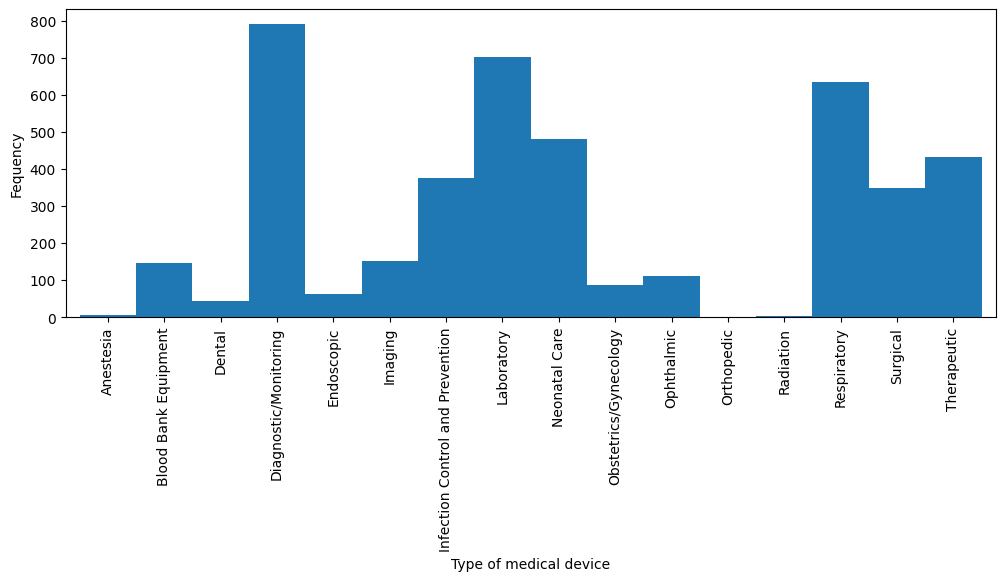

In [14]:
freq_df = dataset['Category'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(12, 4))
ax = freq_df.plot(kind='bar',width=1.0)
ax.set(xlabel = "Type of medical device",
       ylabel = "Fequency")
plt.show()

> With huge inconsitencies in the number of equipment for each category, only 3 equipment category will be included in this forecasting study. They are (1) 'Diagnostic/Monitoring' (2) 'Laboratory' and (3) 'Respiratory'

> A new dataframe cat_df is used for the subsequent sections

In [15]:
cats = ('Diagnostic/Monitoring','Laboratory','Respiratory')
cat_df = dataset[(dataset['Category']==cats[0]) | (dataset['Category']==cats[1]) | (dataset['Category']==cats[2])]
cat_df.head(5)

,Category,Equipment Name,Cost,Serial No.,Date Of Installation,Under Warranty,Functional/ Non-functional,Status
0,Diagnostic/Monitoring,ABG,1000000.0,RG59vtM,2021-04-08,Yes,Functional,Not Available
1,Diagnostic/Monitoring,ABG,1000000.0,WX17vxI,2021-04-08,Yes,Functional,Not Available
6,Laboratory,Automatic Tissue Processor,900000.0,XK58eyC,2021-12-22,No,Functional,Available
7,Laboratory,Automatic Tissue Processor,900000.0,YD42ctW,2006-09-07,No,Non-functional,Not Available
8,Diagnostic/Monitoring,Bed Side Monitor,65000.0,HK09nyG,2021-09-01,Yes,Functional,Available


> Look for missing attributes in cat_dataframe

In [16]:
for i,j in enumerate(cat_df.columns):
    num_missing = (cat_df[[j]].isnull()).sum()
    perc = num_missing/dataset.shape[0]*100
    print('%s. %s, Missing: %d (%.1f%%)' % (i+1,j,num_missing,perc))

1. Category, Missing: 0 (0.0%)
2. Equipment Name, Missing: 0 (0.0%)
3. Cost, Missing: 165 (3.0%)
4. Serial No., Missing: 0 (0.0%)
5. Date Of Installation, Missing: 0 (0.0%)
6. Under Warranty, Missing: 39 (0.7%)
7. Functional/ Non-functional, Missing: 0 (0.0%)
8. Status, Missing: 0 (0.0%)


/var/folders/sq/z4mv25d17y3_fdz56x8p97nr0000gn/T/ipykernel_86454/1883254016.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('%s. %s, Missing: %d (%.1f%%)' % (i+1,j,num_missing,perc))
/var/folders/sq/z4mv25d17y3_fdz56x8p97nr0000gn/T/ipykernel_86454/1883254016.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('%s. %s, Missing: %d (%.1f%%)' % (i+1,j,num_missing,perc))
/var/folders/sq/z4mv25d17y3_fdz56x8p97nr0000gn/T/ipykernel_86454/1883254016.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('%s. %s, Missing: %d (%.1f%%)' % (i+1,j,num_missing,perc))
/var/folders/sq/z4mv25d17y3_fdz56x8p97nr0000gn/T/ipykernel_86454/1883254016.py:4: FutureWarning: Calling float on a single element S

> Next, handle missing values for 'Cost; and 'Under Warranty' attributes

In [17]:
cat_null = cat_df[pd.isnull(cat_df["Under Warranty"])]
cat_null.head(5)

,Category,Equipment Name,Cost,Serial No.,Date Of Installation,Under Warranty,Functional/ Non-functional,Status
2068,Laboratory,Binocular Microscope,30000.0,XM09yyQ,2016-09-07,NaN,Functional,Not Available
2070,Laboratory,Boyles Apparatus,150000.0,NL66poZ,2017-09-11,NaN,Non-functional,Available
2071,Laboratory,Boyles Apparatus,150000.0,EK52buF,2017-09-12,NaN,Non-functional,Not Available
2076,Laboratory,Centrifuse Machine,6500.0,YO10ekZ,2017-09-07,NaN,Functional,Available
2077,Laboratory,Centrifuse Machine,6500.0,LX44yiC,2017-09-07,NaN,Functional,Not Available


In [18]:
print(cat_null.shape)

(39, 8)


> With 39 missing entries and 2129 entries, the analysis decides not to shrink the size of the dataset by dropping entries. Instead, impute all missing entries for 'Under warranty' to 'Yes'

In [19]:
cat_df["Under Warranty"].fillna('Yes', inplace = True)
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2129 entries, 0 to 5590
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Category                    2129 non-null   object        
 1   Equipment Name              2129 non-null   object        
 2   Cost                        1964 non-null   float64       
 3   Serial No.                  2129 non-null   object        
 4   Date Of Installation        2129 non-null   datetime64[ns]
 5   Under Warranty              2129 non-null   object        
 6   Functional/ Non-functional  2129 non-null   object        
 7   Status                      2129 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 149.7+ KB


/var/folders/sq/z4mv25d17y3_fdz56x8p97nr0000gn/T/ipykernel_86454/310842706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df["Under Warranty"].fillna('Yes', inplace = True)


In [20]:
cost_map = {}
equipment_with_missing_cost = set(cat_df[pd.isnull(cat_df["Cost"])]['Equipment Name'].values)
for equip in equipment_with_missing_cost:
    cost_map[equip] = cat_df[cat_df["Equipment Name"] == equip]['Cost'].mean()
print(cost_map)

{'Microscope': 28602.941176470587, 'Semi Auto Analyser': 115277.77777777778, 'Ultrasound Machine': 540000.0, 'Bed Side Monitor': 65000.0, 'Multipara Monitor': 75000.0, 'Binocular Microscope': 29788.732394366198, 'Tube Sealer': 96250.0, 'Hot Air Oven': 22666.666666666668, 'Suction machine': 7015.277777777777, 'Ventilator': 1100000.0, 'Pulse Oximeter': 43135.13513513513, 'Ultrasonography Machine': 398888.8888888889, 'ROTARY MICROTOME': 6500.0, 'Urine Analyser': 75000.0, 'Oxygen Concentrator': 41386.36363636364, 'Spectro Photometer': 80000.0, 'QBC Machine': 105166.66666666667}


In [21]:
for index, row in cat_df[pd.isnull(cat_df["Cost"])].iterrows():
    if row["Equipment Name"] in cost_map:
        cat_df.loc[index, "Cost"] = cost_map[row["Equipment Name"]]

In [22]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2129 entries, 0 to 5590
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Category                    2129 non-null   object        
 1   Equipment Name              2129 non-null   object        
 2   Cost                        2129 non-null   float64       
 3   Serial No.                  2129 non-null   object        
 4   Date Of Installation        2129 non-null   datetime64[ns]
 5   Under Warranty              2129 non-null   object        
 6   Functional/ Non-functional  2129 non-null   object        
 7   Status                      2129 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 214.2+ KB


> All missing data and duplicated data are handled

> Next, check for noisy data

> For 'Functional/Non-functional' attribute, there are 7 unique values. Limit these category to (i) Active/in use, (ii) Not in use (iii) Approved for disposal

> For 'Date of Installation' attribute check the variation by year.

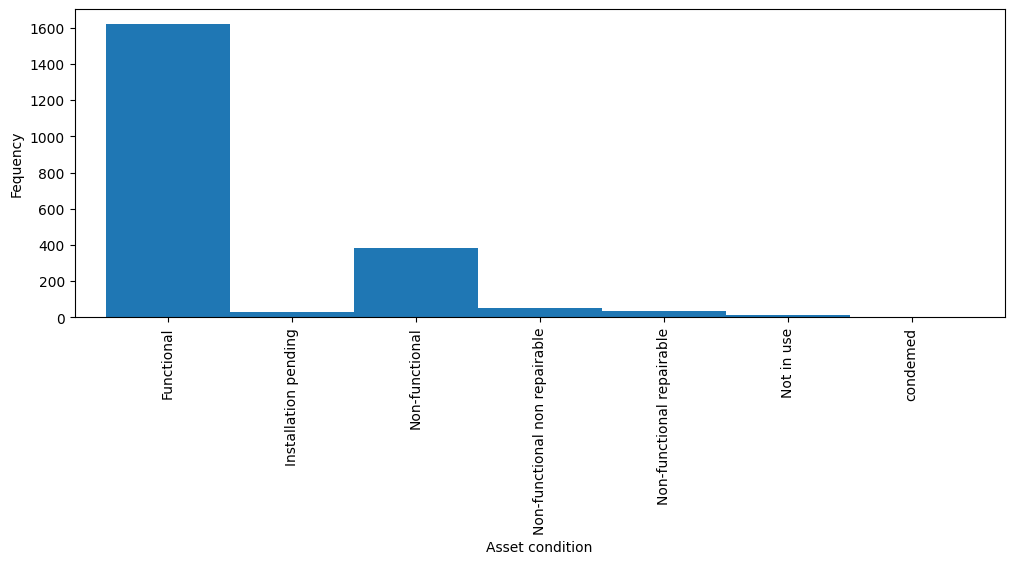

In [23]:
funcFreq_df = cat_df['Functional/ Non-functional'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(12, 4))
ax = funcFreq_df.plot(kind='bar',width=1.0)
ax.set(xlabel = "Asset condition",
       ylabel = "Fequency")
plt.show()

In [24]:
cat_df['Functional/ Non-functional'] = cat_df['Functional/ Non-functional'].replace(['Installation pending','Functional'], 'Active/in use')
cat_df['Functional/ Non-functional'] = cat_df['Functional/ Non-functional'].replace(['Non-functional','Non-functional non repairable','Non-functional repairable'], 'Not in use')
cat_df['Functional/ Non-functional'] = cat_df['Functional/ Non-functional'].replace(['condemed'], 'Approved for disposal')

/var/folders/sq/z4mv25d17y3_fdz56x8p97nr0000gn/T/ipykernel_86454/2926736806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['Functional/ Non-functional'] = cat_df['Functional/ Non-functional'].replace(['Installation pending','Functional'], 'Active/in use')
/var/folders/sq/z4mv25d17y3_fdz56x8p97nr0000gn/T/ipykernel_86454/2926736806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_df['Functional/ Non-functional'] = cat_df['Functional/ Non-functional'].replace(['Non-functional','Non-functiona

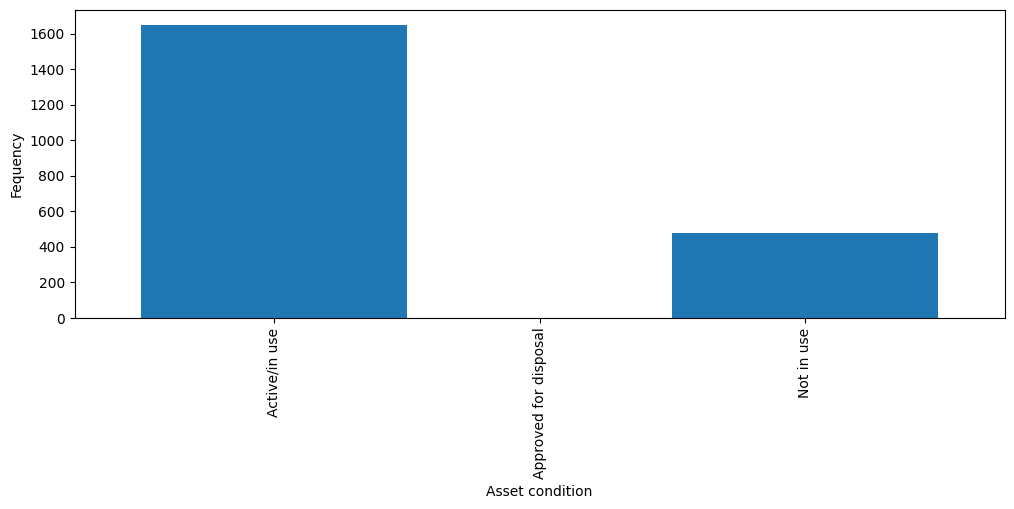

In [25]:
funcFreq_df = cat_df['Functional/ Non-functional'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(12, 4))
ax = funcFreq_df.plot(kind='bar',width=1.0)
ax.set(xlabel = "Asset condition",
       ylabel = "Fequency")
plt.show()

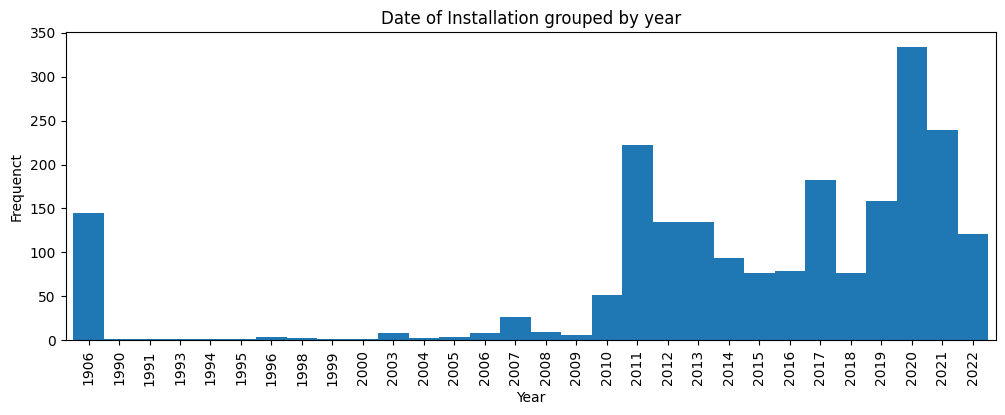

In [26]:
year_df = cat_df.copy()
year_df['Year'] = cat_df['Date Of Installation'].dt.year
yearFreq_df = year_df['Year'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(12, 4))
ax = yearFreq_df.plot(kind='bar',width=1.0)
ax.set_title('Date of Installation grouped by year')
ax.set(xlabel = "Year",
       ylabel = "Frequenct")
plt.show()

> 1906 is an anomaly. Filter cat_df to include only dates from 1990 onwards 

In [27]:
cat_df = cat_df[cat_df['Date Of Installation'].dt.year>=1990]

> All missing data, noisy data and duplicated data are handled

## Part II: Data Transformation

<ul>
    <li> Data Normalization 
    <li> Data Aggregation
    <li> Data Smoothing
    <li> Data Discretization
    <li> Data Encoding
    <li> Attribute Construction
<ul>

> Perform data encoding on 'Category','Under Warranty','Functional/ Non-functional','Status'

> Perform attribute constuction 'Age' of equipment 

In [28]:
year = datetime.date.today().year
cat_df['Age'] = year - cat_df['Date Of Installation'].dt.year
cat_df = cat_df.drop(['Date Of Installation'], axis = 1)

In [29]:
enc_df = cat_df.copy()

In [30]:
numerical_features = ['Age','Cost']
scaler = StandardScaler()
enc_df[numerical_features] = scaler.fit_transform(enc_df[numerical_features])

In [31]:
categorial_features = ['Under Warranty','Functional/ Non-functional','Status']
enc_df = pd.get_dummies(enc_df, columns=categorial_features, prefix=categorial_features)

In [32]:
enc_df.head(4)

,Category,Equipment Name,Cost,Serial No.,Age,Under Warranty_No,Under Warranty_Yes,Functional/ Non-functional_Active/in use,Functional/ Non-functional_Approved for disposal,Functional/ Non-functional_Not in use,Status_Available,Status_Not Available
0,Diagnostic/Monitoring,ABG,4.223621,RG59vtM,-1.047422,False,True,True,False,False,False,True
1,Diagnostic/Monitoring,ABG,4.223621,WX17vxI,-1.047422,False,True,True,False,False,False,True
6,Laboratory,Automatic Tissue Processor,3.761955,XK58eyC,-1.047422,True,False,True,False,False,True,False
7,Laboratory,Automatic Tissue Processor,3.761955,YD42ctW,2.284267,True,False,False,False,True,False,True


In [33]:
enc_df.iloc[:,4:] = enc_df.iloc[:,4:].astype(int)

In [34]:
enc_df.head(4)

,Category,Equipment Name,Cost,Serial No.,Age,Under Warranty_No,Under Warranty_Yes,Functional/ Non-functional_Active/in use,Functional/ Non-functional_Approved for disposal,Functional/ Non-functional_Not in use,Status_Available,Status_Not Available
0,Diagnostic/Monitoring,ABG,4.223621,RG59vtM,-1.0,0,1,1,0,0,0,1
1,Diagnostic/Monitoring,ABG,4.223621,WX17vxI,-1.0,0,1,1,0,0,0,1
6,Laboratory,Automatic Tissue Processor,3.761955,XK58eyC,-1.0,1,0,1,0,0,1,0
7,Laboratory,Automatic Tissue Processor,3.761955,YD42ctW,2.0,1,0,0,0,1,0,1


<Axes: >

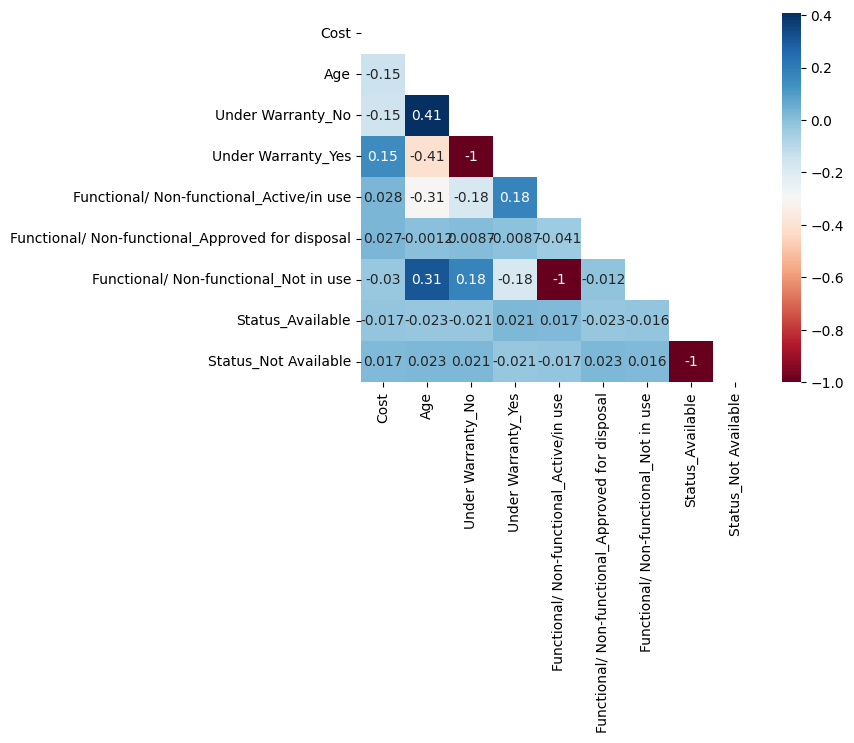

In [35]:
corr = enc_df.iloc[:, [2] + list(range(4, len(enc_df.columns)))].corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, mask=mask)

## Part III: Data Reduction

In [36]:
med_df = enc_df.iloc[:,2:]
med_df.head(5)

,Cost,Serial No.,Age,Under Warranty_No,Under Warranty_Yes,Functional/ Non-functional_Active/in use,Functional/ Non-functional_Approved for disposal,Functional/ Non-functional_Not in use,Status_Available,Status_Not Available
0,4.223621,RG59vtM,-1.0,0,1,1,0,0,0,1
1,4.223621,WX17vxI,-1.0,0,1,1,0,0,0,1
6,3.761955,XK58eyC,-1.0,1,0,1,0,0,1,0
7,3.761955,YD42ctW,2.0,1,0,0,0,1,0,1
8,-0.092962,HK09nyG,-1.0,0,1,1,0,0,1,0


> High demensionality data

In [37]:
print(med_df.columns)
print(len(med_df.columns))

Index(['Cost', 'Serial No.', 'Age', 'Under Warranty_No', 'Under Warranty_Yes',
       'Functional/ Non-functional_Active/in use',
       'Functional/ Non-functional_Approved for disposal',
       'Functional/ Non-functional_Not in use', 'Status_Available',
       'Status_Not Available'],
      dtype='object')
10


In [38]:
pca_df = med_df.iloc[:, [0] + list(range(2, len(med_df.columns)))]

In [39]:
pca_df.head(4)

,Cost,Age,Under Warranty_No,Under Warranty_Yes,Functional/ Non-functional_Active/in use,Functional/ Non-functional_Approved for disposal,Functional/ Non-functional_Not in use,Status_Available,Status_Not Available
0,4.223621,-1.0,0,1,1,0,0,0,1
1,4.223621,-1.0,0,1,1,0,0,0,1
6,3.761955,-1.0,1,0,1,0,0,1,0
7,3.761955,2.0,1,0,0,0,1,0,1


In [40]:
pca = PCA()
pca.fit_transform(pca_df)

array([[ 4.49338762e+00,  2.28513329e-02, -6.61235986e-01, ...,
         1.00797602e-15,  8.37653589e-16, -2.68972319e-15],
       [ 4.49338762e+00,  2.28513329e-02, -6.61235986e-01, ...,
        -1.37297335e-15, -2.56929183e-15, -1.06460430e-15],
       [ 3.84808169e+00,  9.32000577e-02,  7.59337495e-01, ...,
         4.01962386e-16, -1.66012722e-15,  3.01373752e-14],
       ...,
       [ 4.74504230e+00,  5.69036588e-01, -5.89328355e-01, ...,
         1.65762036e-16,  1.83074312e-16, -2.60891984e-16],
       [ 4.46691184e+00,  1.15484634e+00,  9.25002408e-01, ...,
         9.05277872e-17,  1.53493168e-16, -3.14429197e-16],
       [ 4.46691184e+00,  1.15484634e+00,  9.25002408e-01, ...,
         9.05277872e-17,  1.53493168e-16, -3.14429197e-16]])

[3.97817591e-01 2.38059272e-01 1.90051684e-01 1.08514990e-01
 6.52680581e-02 2.88404907e-04 1.53301365e-30 9.72605080e-31
 1.78538399e-31]


Text(0.5, 1.0, 'Plot of eigen variance energy captured by Principle component')

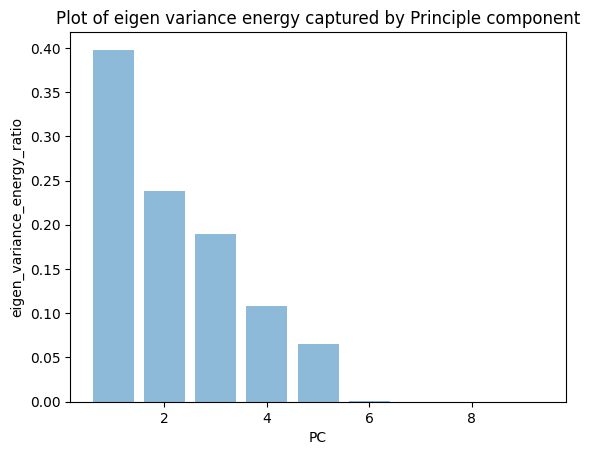

In [41]:
eigen_energy=pca.explained_variance_ratio_
print(eigen_energy)
plt.bar(range(1,10), eigen_energy, alpha=0.5, align='center', label='individual explained variance')
plt.xlabel('PC')
plt.ylabel('eigen_variance_energy_ratio')
plt.title("Plot of eigen variance energy captured by Principle component")

In [42]:
ev = 0
for i, j in enumerate(eigen_energy):
    ev += j
    print("PC %d varaince energy is %f" % (i+1, ev))

PC 1 varaince energy is 0.397818
PC 2 varaince energy is 0.635877
PC 3 varaince energy is 0.825929
PC 4 varaince energy is 0.934444
PC 5 varaince energy is 0.999712
PC 6 varaince energy is 1.000000
PC 7 varaince energy is 1.000000
PC 8 varaince energy is 1.000000
PC 9 varaince energy is 1.000000


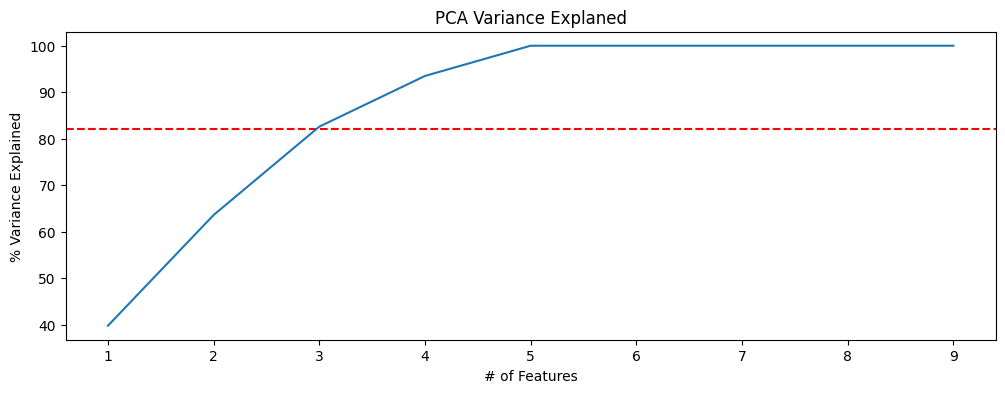

In [43]:
plt.figure(figsize=(12, 4))
plt.title('PCA Variance Explaned')
plt.xlabel('# of Features')
plt.ylabel('% Variance Explained')
plt.axhline(y=82, color='r', linestyle='--')
plt.plot(range(1,10),np.cumsum(np.round(pca.explained_variance_ratio_,decimals=3)*100))
plt.show()

> From the scree plot curve, there are two methods to choose the most appropriate number of principal compnents:

> 1. Kaiser rule: pick PCs with eigenvalues of at least 1.
> 2. Proportion of variance plot: the selected PCs should be able to describe at least 80% of the variance.

In [44]:
pca = PCA(n_components= 3) #covariance matrix
x_pca = pca.fit_transform(pca_df)
print(x_pca.shape)

(1984, 3)


In [45]:
x_pca_df = pd.DataFrame(x_pca, columns=['PC1','PC2','PC3'])
x_pca_df

,PC1,PC2,PC3
0,4.493388,0.022851,-0.661236
1,4.493388,0.022851,-0.661236
2,3.848082,0.093200,0.759337
3,2.965251,3.276817,-0.204644
4,0.364424,-1.446480,0.502291
...,...,...,...
1979,4.466912,1.154846,0.925002
1980,4.348457,1.759043,1.014204
1981,4.745042,0.569037,-0.589328
1982,4.466912,1.154846,0.925002


 > A scree plot displays how much variation each principal component captures from the data. The y axis is eigenvalues, which essentially stand for the amount of variation. Use a scree plot to select the principal components to keep. An ideal curve should be steep, then bends at an “elbow” — this is your cutting-off point — and after that flattens out.

 > The ideal case is to maintain less than 3. The result of excess components results in poor visualization of data. Instead, consider other dimension reduction techniques, such as t-SNE and MDS.

 > PCs should at least describe 80% of the variance. Based on the figure PC 1-3 are enough to describe the data. 

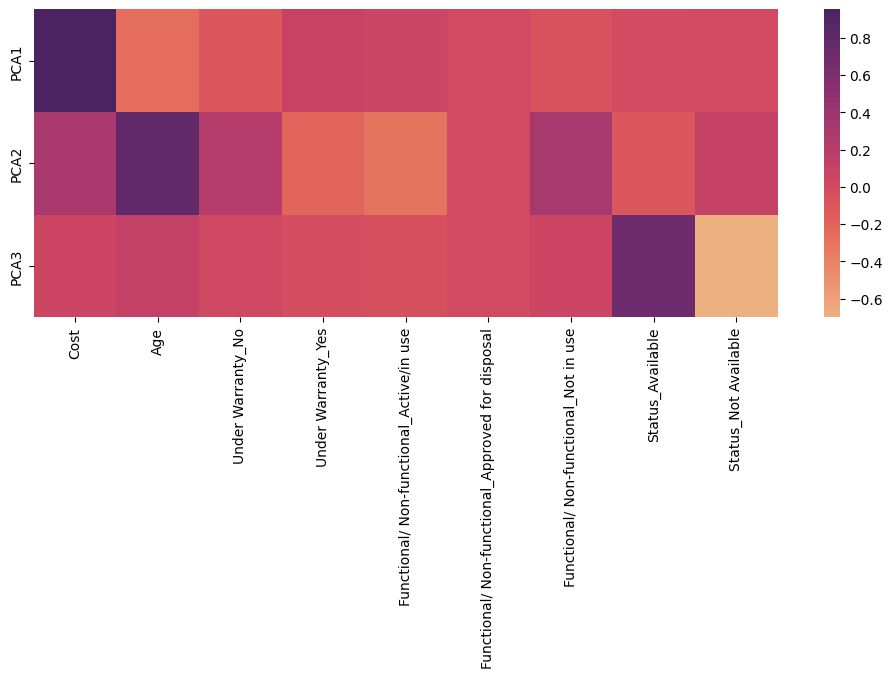

In [46]:
plt.figure(figsize=(12,4))
ax = sns.heatmap(pca.components_[0:3],
                 cmap="flare",
                 yticklabels=[ "PCA"+str(x) for x in range(1,4)],
                 xticklabels=list(pca_df.columns))

In [47]:
components = pd.DataFrame(pca.components_, columns=pca_df.columns)
components.rename(index= lambda x:'PC-' + str(x+1), inplace=True)

# Top 3 positive contributors
pd.DataFrame(components.columns.values[np.argsort(-components.values,axis=1)[:,:3]], 
             index=components.index, columns=['1st Max', '2nd Max','3rd Max'])

,1st Max,2nd Max,3rd Max
PC-1,Cost,Under Warranty_Yes,Functional/ Non-functional_Active/in use
PC-2,Age,Functional/ Non-functional_Not in use,Cost
PC-3,Status_Available,Age,Cost


[pca] >The PCA reduction is performed on the [9] columns of the input dataframe.
[pca] >Processing dataframe..
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[3]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


[clustimage] >WARNING> Colormap [Set1] can not create [1984] unique colors! Available unique colors: [9].


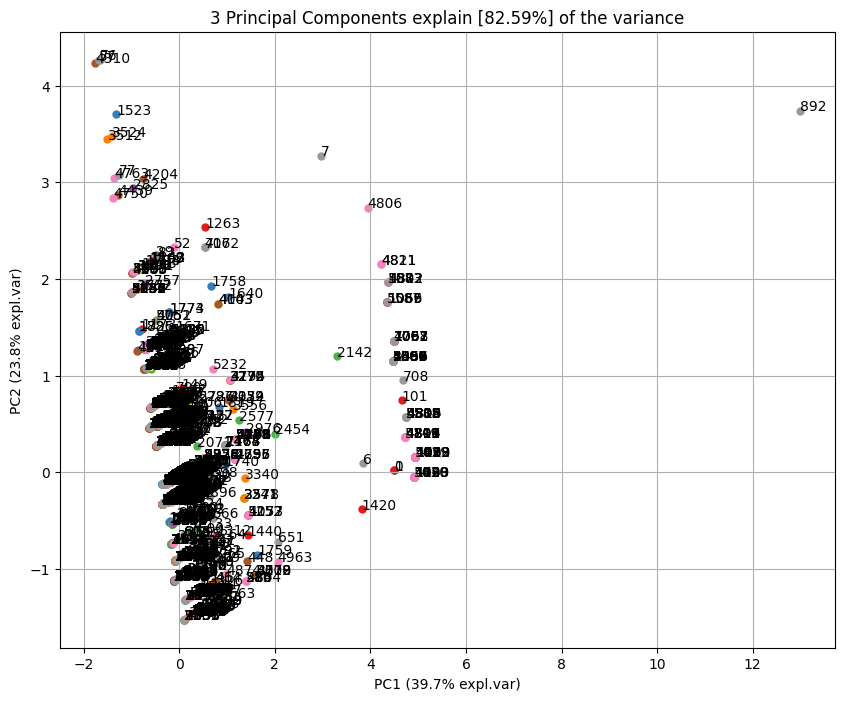

In [48]:
# reduce the data towards 5 PCs
model = pca_2(n_components=3)
results = model.fit_transform(pca_df)
# Plot explained variance
fig, ax = model.scatter(legend=False)

[clustimage] >WARNING> Colormap [Set1] can not create [1984] unique colors! Available unique colors: [9].


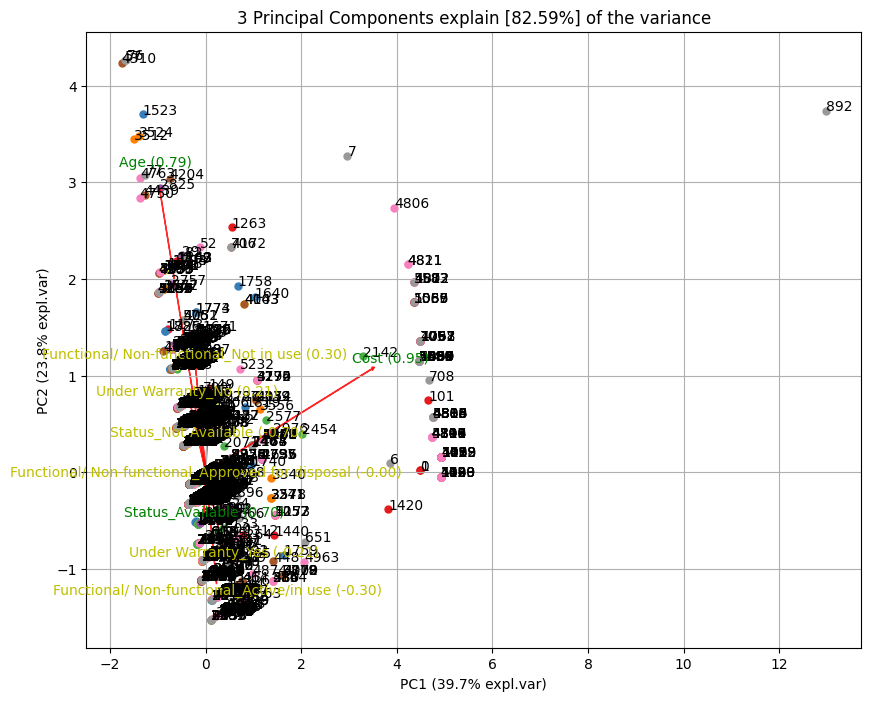

In [49]:
fig, ax = model.biplot(legend=False)

> From the biplot, the eigenvector of 'Cost' and 'Age' features are orthogonal to each other. This signifies that they are linearly independent and do not share a common direction. This is desirable because it allows eeach principal component  to capture a distinct, uncorrelated direction of variance in the data. 

# Model Training

/Users/crys/miniconda3/envs/mldevenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/crys/miniconda3/envs/mldevenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/crys/miniconda3/envs/mldevenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/crys/miniconda3/envs/mldevenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

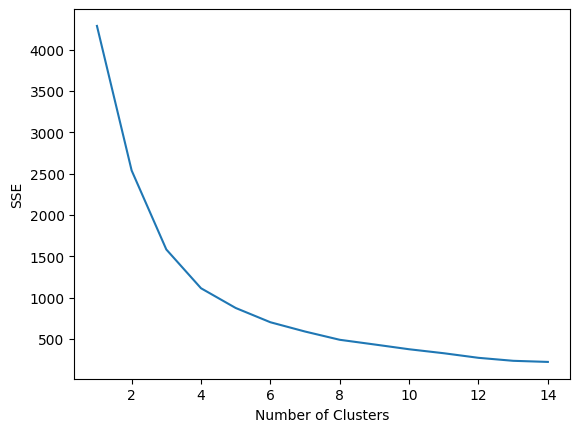

In [50]:
pca_df = pd.DataFrame(x_pca, columns=['PCA1', 'PCA2', 'PCA3'])
pca_df

numClusters = range(1,15)
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(pca_df)
    SSE.append(k_means.inertia_) # Sum of squared distances of samples to their closest cluster center

plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.plot(numClusters, SSE)

In [51]:
k_means = cluster.KMeans(n_clusters=4, max_iter=50, random_state=1)
k_means.fit(pca_df) 
to_cluster_pca_df = pca_df
labels = k_means.labels_
print('labels:', labels)
clusterID = pd.DataFrame(labels, columns=['Cluster ID'])
clusterID

labels: [3 3 3 ... 3 3 3]


/Users/crys/miniconda3/envs/mldevenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Cluster ID
0,3
1,3
2,3
3,3
4,1
...,...
1979,3
1980,3
1981,3
1982,3


In [52]:
# Centroids
centroids = k_means.cluster_centers_
centroids_df= pd.DataFrame(centroids,columns=pca_df.columns)
centroids_df

,PCA1,PCA2,PCA3
0,-0.614021,1.538779,0.202427
1,-0.138689,-0.330712,0.652617
2,-0.130202,-0.073377,-0.739035
3,4.690480,0.851426,0.171505


> With the 3 centroids we can now find out which equipment belongs to which cluster. From the cluster, identify the cluster trends and suggest restocking reccomendations

In [53]:
cat_df['cluster'] = labels

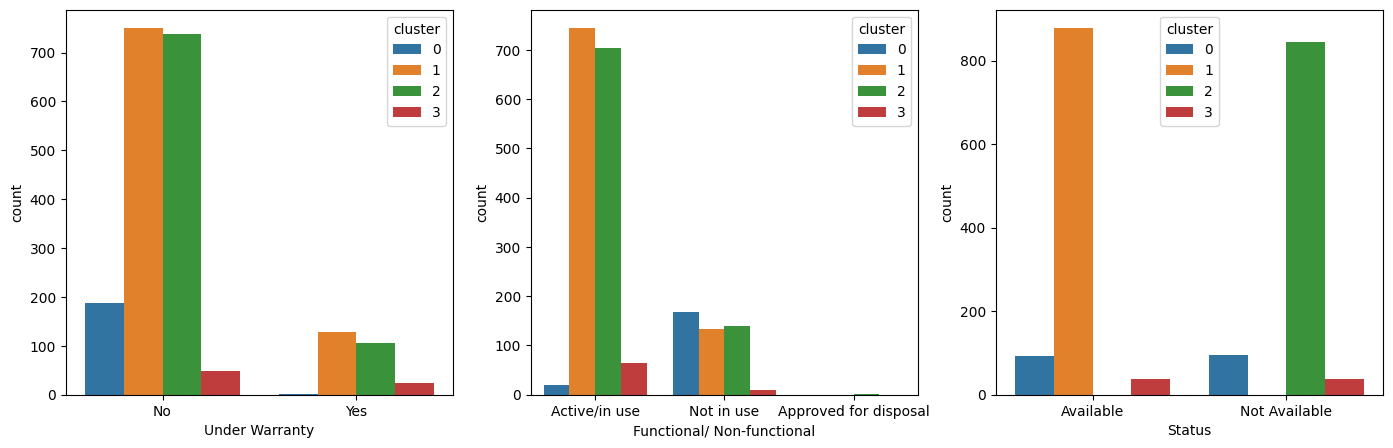

In [54]:
f, axs = plt.subplots(1,3,figsize = (17,5))
sns.countplot(x=cat_df['Under Warranty'],order=cat_df['Under Warranty'].value_counts().index,hue=cat_df['cluster'],ax=axs[0])
sns.countplot(x=cat_df['Functional/ Non-functional'],order=cat_df['Functional/ Non-functional'].value_counts().index,hue=cat_df['cluster'],ax=axs[1])
sns.countplot(x=cat_df['Status'],order=cat_df['Status'].value_counts().index,hue=cat_df['cluster'],ax=axs[2])

plt.show()

> Most equipments do not have awarranty. All equipments in cluster 0 do not have a warranty.

> Equipments in cluster 1&2 are working as normal while equipments in cluster 0&3 have a higher percentage of non usable equipments.

> Equipments in cluster 2 records high usage levels. Equipments in cluster 1 have low usage levels. Equipments in cluster 0&3 have a 50% chance of being available and not avialable

In [55]:
cont_dat = cat_df[['Cost','Age','cluster']]
cont_dat['Cost'] = cont_dat['Cost']/1000
cont_dat.groupby('cluster').agg(['median' ,'mean']).T

/var/folders/sq/z4mv25d17y3_fdz56x8p97nr0000gn/T/ipykernel_86454/1909897409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cont_dat['Cost'] = cont_dat['Cost']/1000


cluster              0          1          2            3
Cost median  30.000000  30.000000  30.000000  1100.000000
     mean    53.060671  43.751370  45.404082  1110.810811
Age  median  12.000000   5.000000   5.000000     2.000000
     mean    14.500000   5.851936   6.068720     4.567568

- Recommendations

> Cluster 2 and 1 tends to contain newly purchased items where most items frequently used and most items are working in normal conditions. Hence, equipments in this cluster are lablled as 'Healthy'

> Equipment within cluster 0 has an higher likelihood of not functioning properly or experiencing issues. Additionally, with no warranty on these equipment despite its high shelf life, these items should be reevaluated for restock or replacement. Hence, this cluster is labelled as 'Unhealthy'.

In [79]:
cat_df

,Category,Equipment Name,Cost,Serial No.,Under Warranty,Functional/ Non-functional,Status,Age,cluster
0,Diagnostic/Monitoring,ABG,1000000.0,RG59vtM,Yes,Active/in use,Not Available,2,3
1,Diagnostic/Monitoring,ABG,1000000.0,WX17vxI,Yes,Active/in use,Not Available,2,3
6,Laboratory,Automatic Tissue Processor,900000.0,XK58eyC,No,Active/in use,Available,2,3
7,Laboratory,Automatic Tissue Processor,900000.0,YD42ctW,No,Not in use,Not Available,17,3
8,Diagnostic/Monitoring,Bed Side Monitor,65000.0,HK09nyG,Yes,Active/in use,Available,2,1
...,...,...,...,...,...,...,...,...,...
5586,Respiratory,Ventilator,1100000.0,EE57avX,No,Active/in use,Available,9,3
5587,Respiratory,Ventilator,1100000.0,IW61htP,No,Not in use,Available,9,3
5588,Respiratory,Ventilator,1100000.0,FX29zfT,No,Active/in use,Not Available,1,3
5589,Respiratory,Ventilator,1100000.0,NP47giD,No,Active/in use,Available,9,3


In [69]:
import joblib
joblib.dump(pca, 'pca_model.pkl')


['pca_model.pkl']

In [70]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']